# SBRT 2024 - An Introduction to Generative Artificial Intelligence with Applications in Telecommunications

This notebook only organize the code from [Channel_Estimation_cGAN](https://github.com/YudiDong/Channel_Estimation_cGAN) with implementation from Paper ["Channel estimation for one-bit multiuser massive MIMO using conditional GAN"](https://ieeexplore.ieee.org/abstract/document/9246559?casa_token=FHE0zDNfNogAAAAA:4ZkrxY2-EyzW2j4CrunAgoTd9aR0MzgBjVnHpj8Zqb1BR37mNMnA151LgAGt7kcCtXIPkTxANg) by Yudi Dong.

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from GAN.cGANGenerator import Generator
from GAN.cGANDiscriminator import Discriminator
from GAN.data_preprocess import load_image_train, load_image_test, load_image_test_y
from tempfile import TemporaryFile
from scipy.io import loadmat, savemat
import datetime
import h5py
import hdf5storage
import skfuzzy as fuzz

2024-09-23 11:24:05.713836: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-23 11:24:05.713857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# General initialization
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.enable_eager_execution(config=config)
layers = tf.keras.layers

In [3]:
# data path
path = "../Data_Generation_matlab/Gan_Data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat"
BATCH_SIZE = 1
# model
generator = Generator()
discriminator = Discriminator()
# optimizer
generator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.RMSPropOptimizer(2e-5)

2024-09-23 11:24:07.048167: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-23 11:24:07.049091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-09-23 11:24:07.069353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-23 11:24:07.069637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4050 Laptop GPU computeCapability: 8.9
coreClock: 2.355GHz coreCount: 20 deviceMemorySize: 5.76GiB deviceMemoryBandwidth: 178.84GiB/s
2024-09-23 11:24:07.069799: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file:

## Dataset

The dataset contains the correct label represented by the target channel with dimensions (1 x # of BS Antennas x # users x 2) while the input contains (1 x # of BS Antennas x Pilot length x 2). The dimension with value 2 represents the real and imaginary part from complex samples. Here, it trains for only one type of pilot. Therefore, we don't need to pass the pilots in the input.

In [4]:
for bi, (target, input_image) in enumerate(load_image_train(path)):
    print(f"Target channel - sample shape: {target.shape}")
    print(f"Input - sample shape: {input_image.shape}")
    break

Target channel - sample shape: (1, 64, 32, 2)
Input - sample shape: (1, 64, 8, 2)


## Discriminator and Generator loss functions

In [5]:
"""
Discriminator loss:
The discriminator loss function takes 2 inputs; real images, generated images
real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since the real images)
generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since the fake images)
Then the total_loss is the sum of real_loss and the generated_loss
"""


def discriminator_loss(disc_real_output, disc_generated_output):
    """disc_real_output = [real_target]
    disc_generated_output = [generated_target]
    """
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(disc_real_output), logits=disc_real_output
    )  # label=1
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output
    )  # label=0
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss

In [6]:
"""
Generator loss:
It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L2 loss between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l2_loss, where LAMBDA = 100. 
This value was decided by the authors of the paper.
"""


def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    """
    disc_generated_output: output of Discriminator when input is from Generator
    gen_output:  output of Generator (i.e., estimated H)
    target:  target image
    l2_weight: weight of L2 loss
    """
    # GAN loss
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(disc_generated_output), logits=disc_generated_output
    )
    # L2 loss
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss

In [7]:
def generated_image(model, test_input, tar, t=0):
    """Display  the results of Generator"""
    prediction = model(test_input)
    # plt.figure(figsize=(15, 15))
    display_list = [
        np.squeeze(test_input[:, :, :, 0]),
        np.squeeze(tar[:, :, :, 0]),
        np.squeeze(prediction[:, :, :, 0]),
    ]

    title = ["Input Y", "Target H", "Prediction H"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_" + str(t) + ".png"))

## Training one step

Train with one sample from the dataset (pair input and target). It calculates the losses to the discriminator and generator and update the neural network parameters.

In [8]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)  # input -> generated_target
        disc_real_output = discriminator(target)  # [input, target] -> disc output
        disc_generated_output = discriminator(
            gen_output
        )  # [input, generated_target] -> disc output
        # print("*", gen_output.shape, disc_real_output.shape, disc_generated_output.shape)

        # calculate loss
        gen_loss = generator_loss(disc_generated_output, gen_output, target)  # gen loss
        disc_loss = discriminator_loss(
            disc_real_output, disc_generated_output
        )  # disc loss

    # gradient
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )
    # apply gradient
    generator_optimizer.apply_gradients(
        zip(generator_gradient, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradient, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss

## Training over epochs

We take the samples from the dataset and apply in the `train_step()` function. We collect loss values to watch the training progress.

In [9]:
def train(epochs):
    nm = []
    ep = []
    start_time = datetime.datetime.now()
    for epoch in range(epochs):
        print("-----\nEPOCH:", epoch)
        # train
        for bi, (target, input_image) in enumerate(load_image_train(path)):
            elapsed_time = datetime.datetime.now() - start_time
            gen_loss, disc_loss = train_step(input_image, target)
            print(
                "B/E:",
                bi,
                "/",
                epoch,
                ", Generator loss:",
                gen_loss.numpy(),
                ", Discriminator loss:",
                disc_loss.numpy(),
                ", time:",
                elapsed_time,
            )
        # generated and see the progress
        for bii, (tar, inp) in enumerate(load_image_test(path)):
            if bii == 100:
                generated_image(generator, inp, tar, t=epoch + 1)

        # save checkpoint
        # if (epoch + 1) % 2 == 0:
        ep.append(epoch + 1)
        # generator.save_weights(os.path.join(BASE_PATH, "weights/generator_"+str(epoch)+".h5"))
        # discriminator.save_weights(os.path.join(BASE_PATH, "weights/discriminator_"+str(epoch)+".h5"))

        realim, inpuim = load_image_test_y(path)
        prediction = generator(inpuim)

        nm.append(fuzz.nmse(np.squeeze(realim), np.squeeze(prediction)))

        if epoch == epochs - 1:
            nmse_epoch = TemporaryFile()
            np.save(nmse_epoch, nm)

        # Save the predicted Channel
        matfiledata = {}  # make a dictionary to store the MAT data in
        matfiledata["predict_Gan_0_dB_Indoor2p4_64ant_32users_8pilot"] = np.array(
            prediction
        )  # *** u prefix for variable name = unicode format, no issues thru Python 3.5; advise keeping u prefix indicator format based on feedback despite docs ***
        hdf5storage.write(
            matfiledata,
            ".",
            "Results/Eest_cGAN_"
            + str(epoch + 1)
            + "_0db_Indoor2p4_64ant_32users_8pilot.mat",
            matlab_compatible=True,
        )

        # plt.figure()
        # plt.plot(ep, nm, "^-r")
        # plt.xlabel("Epoch")
        # plt.ylabel("NMSE")
        # plt.show()

    return nm, ep

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 59.732285 , Discriminator loss: 1.3912764 , time: 0:00:00.288836
B/E: 1 / 0 , Generator loss: 58.701828 , Discriminator loss: 1.3945202 , time: 0:00:00.875278
B/E: 2 / 0 , Generator loss: 59.383636 , Discriminator loss: 1.3924241 , time: 0:00:01.119388
B/E: 3 / 0 , Generator loss: 61.2733 , Discriminator loss: 1.3891299 , time: 0:00:01.340955
B/E: 4 / 0 , Generator loss: 60.937874 , Discriminator loss: 1.3903589 , time: 0:00:01.572460
B/E: 5 / 0 , Generator loss: 59.920036 , Discriminator loss: 1.3903692 , time: 0:00:01.806850
B/E: 6 / 0 , Generator loss: 59.346626 , Discriminator loss: 1.3929065 , time: 0:00:02.043037
B/E: 7 / 0 , Generator loss: 61.27639 , Discriminator loss: 1.3893939 , time: 0:00:02.278691
B/E: 8 / 0 , Generator loss: 58.582363 , Discriminator loss: 1.3906803 , time: 0:00:02.514150
B/E: 9 / 0 , Generator loss: 60.075535 , Discriminator loss: 1.3899248 , time: 0:00:02.749088
B/E: 10 / 0 , Generator loss: 59.38485 , Discrim

2024-09-23 11:30:13.494785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 217579520 exceeds 10% of free system memory.
2024-09-23 11:30:13.535987: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 348127232 exceeds 10% of free system memory.
2024-09-23 11:30:15.091319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 348127232 exceeds 10% of free system memory.
2024-09-23 11:30:15.154792: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 348127232 exceeds 10% of free system memory.
2024-09-23 11:30:15.230310: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 435159040 exceeds 10% of free system memory.


-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 32.09547 , Discriminator loss: 0.31915548 , time: 0:06:08.577317
B/E: 1 / 1 , Generator loss: 33.065742 , Discriminator loss: 0.34467566 , time: 0:06:08.806065
B/E: 2 / 1 , Generator loss: 28.145918 , Discriminator loss: 4.51936 , time: 0:06:09.040763
B/E: 3 / 1 , Generator loss: 37.294132 , Discriminator loss: 0.92714334 , time: 0:06:09.271061
B/E: 4 / 1 , Generator loss: 44.35319 , Discriminator loss: 1.2255179 , time: 0:06:09.494642
B/E: 5 / 1 , Generator loss: 29.985207 , Discriminator loss: 0.45548767 , time: 0:06:09.722391
B/E: 6 / 1 , Generator loss: 41.065002 , Discriminator loss: 0.14086029 , time: 0:06:09.961436
B/E: 7 / 1 , Generator loss: 40.405575 , Discriminator loss: 0.74152 , time: 0:06:10.198012
B/E: 8 / 1 , Generator loss: 36.69084 , Discriminator loss: 0.48469645 , time: 0:06:10.431288
B/E: 9 / 1 , Generator loss: 42.727417 , Discriminator loss: 0.19650954 , time: 0:06:10.669720
B/E: 10 / 1 , Generator loss: 31.338087 , Dis

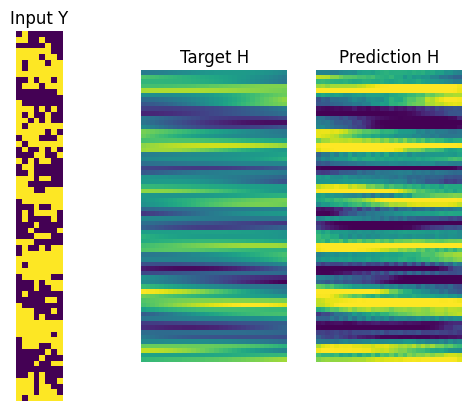

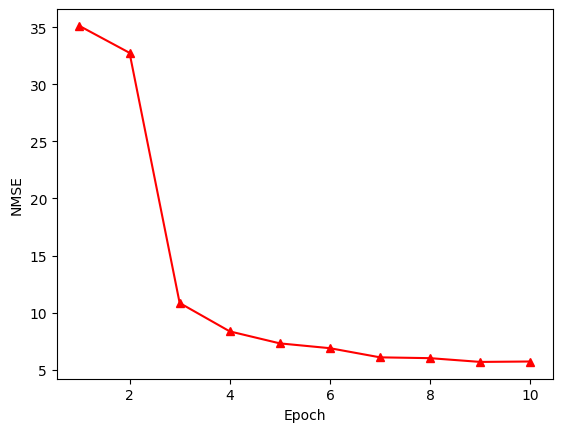

In [10]:
nm, ep = train(epochs=10)
plt.figure()
plt.plot(ep, nm, "^-r")
plt.xlabel("Epoch")
plt.ylabel("NMSE")
plt.show()